In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import newton

from CurveDataFetcher import CurveDataFetcher 
from CurveBuilder import get_spot_rates_bootstrapper, ql_piecewise_method_pretty
from CurveInterpolator import GeneralCurveInterpolator

from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_mles_ols,
)

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

In [2]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True)

# Curveset Filtering Strategies: 

## Using Only the On-The-Runs (Most recently issued):
- Ignoring any liquidty premium
- US Treasury's CMT Rates are derived from just OTRs

In [3]:
as_of_date = datetime(2024, 9, 12)
quote_type = "eod"

curve_set_otr_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True, 
    use_github=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
)

curve_set_otr_df = curve_set_otr_df[curve_set_otr_df["is_on_the_run"]]
curve_set_otr_df

,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,security_term,original_security_term,eod_price,eod_yield,rank
3,912797LS4,Bill,2024-09-05,2024-09-10,2024-10-08,0.071233,NaN,5.171000,True,"Oct 24s, 17-Week",4-Week,17-Week,99.653472,5.147097,13.0
7,912797MA2,Bill,2024-09-05,2024-09-10,2024-11-05,0.147945,NaN,5.150000,True,"Nov 24s, 17-Week",8-Week,17-Week,99.269778,5.154116,9.0
16,912797MW4,Bill,2024-09-04,2024-09-10,2025-01-07,0.320548,NaN,4.956000,True,"Jan 25s, 17-Week",17-Week,17-Week,98.469444,4.953446,0.0
27,912797LP0,Bill,2024-09-09,2024-09-12,2024-12-12,0.249315,NaN,5.025000,True,"Dec 24s, 26-Week",13-Week,26-Week,98.787500,5.023010,10.0
37,912797MT1,Bill,2024-09-09,2024-09-12,2025-03-13,0.498630,NaN,4.701000,True,"Mar 25s, 26-Week",26-Week,26-Week,97.717389,4.671862,0.0
50,912797MH7,Bill,2024-09-03,2024-09-05,2025-09-04,0.978082,NaN,4.345000,True,"Sep 25s, 52-Week",52-Week,52-Week,96.113667,4.106519,0.0
74,91282CLH2,Note,2024-08-27,2024-09-03,2026-08-31,1.967123,3.750,NaN,True,"Aug 26s, 2-Year",2-Year,2-Year,100.187500,3.649302,0.0
110,91282CLG4,Note,2024-08-06,2024-08-15,2027-08-15,2.923288,3.750,NaN,True,"Aug 27s, 3-Year",3-Year,3-Year,100.656250,3.510152,0.0
169,91282CLK5,Note,2024-08-28,2024-09-03,2029-08-31,4.969863,3.625,NaN,True,"Aug 29s, 5-Year",5-Year,5-Year,100.718750,3.465808,0.0
253,91282CLJ8,Note,2024-08-29,2024-09-03,2031-08-31,6.969863,3.750,NaN,True,"Aug 31s, 7-Year",7-Year,7-Year,101.125000,3.565872,0.0


## Liquidity Premium Filtering
- Practical for RV/Par Curve Builds
- Explored in Gurkaynak, Sack, Wright 2006, [Paper](https://www.federalreserve.gov/pubs/feds/2006/200628/200628abs.html)
- Most Sell Side Rate Strategy Teams employ some kind of liquidity premium filtering for zero curve estimation/par curve construction
- General Method:
  - Remove On-The-Runs, First Off-the-runs, Double olds (Some discretion with specifc maturity buckets)
  - Remove TBills (and/or CUSIPs with time to maturity less than x-years - can use GC repo/other MM rate for short end construction)
  - Remove CTDs
  - Remove CUSIPs trading significantly special in repo (JPM excludes securities with 6-month repo rates that are 25bp or more below 6-month GC repo rates)
  - Remove low free float CUSIPs (from JPM, free float = amount issued less SOMA ownership and bonds held in stripped form - $5bn or less)

- Specifc numbers up to your discretion

In [5]:
as_of_date = datetime(2024, 9, 12)
quote_type = "eod"

curve_set_filtered_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    use_github=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
)

# remove OTRs and first off the runs, double olds
curve_set_filtered_df = curve_set_filtered_df[
    (curve_set_filtered_df["rank"] != 0)
    & (curve_set_filtered_df["rank"] != 1)
    # & (curve_set_filtered_df["rank"] != 2)
]

# remove TBills
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["security_type"] != "Bill"
]

# remove low free float bonds (< $8bn)
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["free_float"] > 5000
]

# filter out bonds very close to maturity
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["time_to_maturity"] > 30 / 360
]

# remove CTDs (this is a TODO)
# curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["is_ctd"] == False]

# remove cusips trading special in repo (this is a TODO)
# curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["is_trading_special"] == False]

curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

curve_set_filtered_df

Using SOMA Holdings Data As of 2024-09-11
Using STRIPping Data As of 2024-08-31 00:00:00


,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,...,parValue,percentOutstanding,est_outstanding_amt,corpus_cusip,outstanding_amt,portion_unstripped_amt,portion_stripped_amt,reconstituted_amt,free_float,rank
76,91282CDB4,Note,2021-10-12,2021-10-15,2024-10-15,0.090411,0.625,NaN,False,"Oct 24s, 3-Year",...,4.364017e+09,0.069976,6.236404e+10,912821GN9,6.236404e+10,62330444.4,3.360000e+07,0.0,57966.4277,34.0
52,91282CFQ9,Note,2022-10-25,2022-10-31,2024-10-31,0.134247,4.375,NaN,False,"Oct 24s, 2-Year",...,0.000000e+00,NaN,NaN,912821JY2,4.199464e+10,41963280.8,3.136000e+07,0.0,41963.2808,22.0
171,9128283D0,Note,2017-10-26,2017-10-31,2024-10-31,0.134247,2.250,NaN,False,"Oct 24s, 7-Year",...,6.865383e+09,0.239208,2.870049e+10,9128203U9,2.870049e+10,28687689.9,1.280000e+07,0.0,21822.3065,82.0
112,912828YM6,Note,2019-10-23,2019-10-31,2024-10-31,0.134247,1.500,NaN,False,"Oct 24s, 5-Year",...,1.536157e+10,0.339207,4.528664e+10,912821DC6,4.528664e+10,45235441.2,5.120000e+07,0.0,29873.8744,57.0
77,91282CDH1,Note,2021-11-08,2021-11-15,2024-11-15,0.175342,0.750,NaN,False,"Nov 24s, 3-Year",...,3.476853e+10,0.393338,8.839359e+10,912821GT6,8.839359e+10,88372791.6,2.080000e+07,0.0,53604.2648,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,912810TN8,Bond,2023-04-13,2023-04-17,2053-02-15,28.446575,3.625,NaN,False,"Feb 53s, 30-Year",...,9.367420e+09,0.141965,6.598403e+10,912803GP2,6.598403e+10,50776147.7,1.520788e+10,1928840.0,41408.7278,6.0
389,912810TR9,Bond,2023-07-13,2023-07-17,2053-05-15,28.690411,3.625,NaN,False,"May 53s, 30-Year",...,5.723292e+09,0.091437,6.259307e+10,912803GS6,6.259307e+10,39896116.8,2.269696e+10,5104270.0,34172.8249,5.0
390,912810TT5,Bond,2023-10-12,2023-10-16,2053-08-15,28.942466,4.125,NaN,False,"Aug 53s, 30-Year",...,8.606596e+09,0.120247,7.157430e+10,912803GU1,7.157430e+10,60954881.0,1.061942e+10,991450.0,52348.2848,4.0
391,912810TV0,Bond,2024-01-11,2024-01-16,2053-11-15,29.194521,4.750,NaN,False,"Nov 53s, 30-Year",...,4.567153e+08,0.006874,6.644364e+10,912803GW7,6.644364e+10,56812091.9,9.631553e+09,1679110.0,56355.3766,3.0


## Using Market Observed Zero Rates (P-STRIPs, C-STRIPs, TBills)
- Explored in Brian Sack's [***Using Treasury STRIPS to Measure the Yield Curve***](https://www.federalreserve.gov/pubs/feds/2000/200042/200042pap.pdf)

**Note: We're using quotes observed from public.com so we don't have much historical data**

### Market Observed YTMs from P-STRIPs:

In [7]:
as_of_date = datetime(2024, 9, 12)

curve_set_strips_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True, 
    use_github=True, 
    include_corpus_cusip=True,
)

In [8]:
pstrips_dict_df = curve_data_fetcher.publicdotcom_data_fetcher.public_dotcom_timeseries_api(
    cusips=curve_set_strips_df[curve_set_strips_df["security_type"] != "Bill"][
        "corpus_cusip"
    ].to_list(),
    start_date=as_of_date,
    end_date=as_of_date,
)
pstrips_quotes_df = pd.DataFrame(
    [
        {
            "corpus_cusip": cusip,
            "pstrip_price": df.iloc[-1]["Price"],
            "pstrip_ytm": df.iloc[-1]["YTM"],
        }
        for cusip, df in pstrips_dict_df.items()
        if not df.empty
    ]
)
pstrips_quotes_df = pd.merge(
    curve_set_strips_df[
        [
            "cusip",
            "label",
            "issue_date",
            "maturity_date",
            "time_to_maturity",
            "corpus_cusip",
        ]
    ],
    right=pstrips_quotes_df,
    on="corpus_cusip",
)

pstrips_quotes_df

,cusip,label,issue_date,maturity_date,time_to_maturity,corpus_cusip,pstrip_price,pstrip_ytm
0,91282CFN6,"Sep 24s, 2-Year",2022-09-30,2024-09-30,0.049315,912821JT3,99.7912,4.504785
1,91282CFQ9,"Oct 24s, 2-Year",2022-10-31,2024-10-31,0.134247,912821JY2,99.4401,4.293138
2,91282CFX4,"Nov 24s, 2-Year",2022-11-30,2024-11-30,0.216438,912821KD6,99.1002,4.260315
3,91282CGD7,"Dec 24s, 2-Year",2023-01-03,2024-12-31,0.301370,912821KH7,98.7640,4.202130
4,91282CGG0,"Jan 25s, 2-Year",2023-01-31,2025-01-31,0.386301,912821KN4,98.4269,4.178153
...,...,...,...,...,...,...,...,...
186,912810SX7,"May 51s, 30-Year",2021-07-15,2051-05-15,26.687671,912803FY4,34.1692,4.108803
187,912810SZ2,"Aug 51s, 30-Year",2021-10-15,2051-08-15,26.939726,912803GA5,33.8879,4.101531
188,912810TD0,"Feb 52s, 30-Year",2022-04-18,2052-02-15,27.443836,912803GE7,33.4107,4.078625
189,912810TJ7,"Aug 52s, 30-Year",2022-10-17,2052-08-15,27.942466,912803GK3,33.0803,4.041601


### Market Observed YTMs from C-STRIPs:

In [9]:
cstrips_curve_set_df = pd.read_excel(r"C:\Users\chris\Curvy-CUSIPs\data\cstrips_info.xlsx")
cstrips_curve_set_df["time_to_maturity"] = (cstrips_curve_set_df["maturity_date"] - as_of_date).dt.days / 365

cstrips_dict_df = curve_data_fetcher.publicdotcom_data_fetcher.public_dotcom_timeseries_api(
    cusips=cstrips_curve_set_df["cusip"].to_list(),
    start_date=as_of_date,
    end_date=as_of_date,
    max_concurrent_tasks=64,
)
cstrips_quotes_df = pd.DataFrame(
    [
        {
            "cusip": cusip,
            "cstrip_price": df.iloc[-1]["Price"],
            "cstrip_ytm": df.iloc[-1]["YTM"],
        }
        for cusip, df in cstrips_dict_df.items()
        if not df.empty
    ]
)
cstrips_quotes_df = pd.merge(
    cstrips_curve_set_df[
        [
            "cusip",
            "label",
            "maturity_date",
            "time_to_maturity",
        ]
    ],
    right=cstrips_quotes_df,
    on="cusip",
)

cstrips_quotes_df

,cusip,label,maturity_date,time_to_maturity,cstrip_price,cstrip_ytm
0,912833LT5,"Nov 24, UST STRIPPED INT PMT",2024-11-15,0.175342,99.2153,4.594360
1,912833LU2,"Feb 25, UST STRIPPED INT PMT",2025-02-15,0.427397,98.3032,4.075677
2,912833LV0,"May 25, UST STRIPPED INT PMT",2025-05-15,0.671233,97.2306,4.260728
3,912833LW8,"Aug 25, UST STRIPPED INT PMT",2025-08-15,0.923288,96.4396,4.010460
4,912833LX6,"Nov 25, UST STRIPPED INT PMT",2025-11-15,1.175342,95.5592,3.951357
...,...,...,...,...,...,...
105,912834D47,"Aug 52, UST STRIPPED INT PMT",2052-08-15,27.942466,32.1807,4.144389
106,912834F29,"Nov 52, UST STRIPPED INT PMT",2052-11-15,28.194521,32.1555,4.109534
107,912834G93,"May 53, UST STRIPPED INT PMT",2053-05-15,28.690411,31.9216,4.063463
108,912834H84,"Aug 53, UST STRIPPED INT PMT",2053-08-15,28.942466,31.8538,4.034989


### Market Observed YTMs from TBills:

In [10]:
tbill_curve_set_df = curve_set_strips_df[
    (curve_set_strips_df["security_type"] == "Bill")
    & (curve_set_strips_df["time_to_maturity"] > 1 / 360)
]

tbill_quotes = (
    curve_data_fetcher.publicdotcom_data_fetcher.public_dotcom_timeseries_api(
        cusips=tbill_curve_set_df["cusip"].to_list(),
        start_date=as_of_date,
        end_date=as_of_date,
    )
)

tbill_quotes_df = pd.DataFrame(
    [
        {
            "cusip": cusip,
            "tbill_price": df.iloc[-1]["Price"],
            "tbill_ytm": df.iloc[-1]["YTM"],
        }
        for cusip, df in tbill_quotes.items()
        if not df.empty
    ]
)
tbill_quotes_df = pd.merge(
    tbill_curve_set_df[
        [
            "cusip",
            "label",
            "maturity_date",
            "time_to_maturity",
        ]
    ],
    right=tbill_quotes_df,
    on="cusip",
)

tbill_quotes_df

,cusip,label,maturity_date,time_to_maturity,tbill_price,tbill_ytm
0,912797LH8,"Sep 24s, 17-Week",2024-09-17,0.013699,99.9392,5.468179
1,912797LJ4,"Sep 24s, 17-Week",2024-09-24,0.032877,99.8180,5.955778
2,912797LK1,"Oct 24s, 17-Week",2024-10-01,0.052055,99.7262,5.475081
3,912797LS4,"Oct 24s, 17-Week",2024-10-08,0.071233,99.6304,5.321733
4,912797LT2,"Oct 24s, 17-Week",2024-10-15,0.090411,99.5369,5.209262
5,912797LU9,"Oct 24s, 17-Week",2024-10-22,0.109589,99.4389,5.179015
6,912797LV7,"Oct 24s, 17-Week",2024-10-29,0.128767,99.3357,5.198353
7,912797MA2,"Nov 24s, 17-Week",2024-11-05,0.147945,99.2408,5.156587
8,912797MB0,"Nov 24s, 17-Week",2024-11-12,0.167123,99.1478,5.113120
9,912797MC8,"Nov 24s, 17-Week",2024-11-19,0.186301,99.0667,5.014746


# Curve Construction Strategies - To Bootstrap or to Interpolate???

## Zero Curve Estimation: Quantlib Bootstrapping + Interpolation on OTR Curveset

In [11]:
bs_methods = [
    "ql_plld", # PiecewiseLogLinearDiscount
    "ql_lz", # Piecewise Linear Zero
    "ql_spd", # PiecewiseSplineCubicDiscount
    "ql_mcf", # PiecewiseConvexMonotoneForward 
    "ql_mlpcd", # PiecewiseMonotonicLogParabolicCubicDiscount
    "ql_f_nss", # SvenssonFitting
]
cc_spot_rates_dict = get_spot_rates_bootstrapper(
    curve_set_df=curve_set_otr_df,
    as_of_date=as_of_date,
    on_rate=5.31,
    ql_bootstrap_interp_methods=bs_methods,
    interpolated_months_num=361,
    return_ql_zero_curve=True,
    # daily_interpolation=True,
    return_scipy_interp_func=True,
    continuous_compounded_zero=True
)

cc_spot_rates_dict["spot_rate_df"]

Get Spot Rates - multiple bs methods passed - returning ql zero curve based on first bs method


,maturity_date,time_to_maturity,ql_plld_spot_rate,ql_lz_spot_rate,ql_spd_spot_rate,ql_mcf_spot_rate,ql_mlpcd_spot_rate,ql_f_nss_spot_rate,avg_spot_rate
0,2024-09-12,0.002778,5.310000,5.310000,5.310000,5.310000,5.310000,5.310000,5.310000
1,2024-10-15,0.083333,5.074876,5.077892,5.081312,5.079058,5.080060,5.128295,5.086915
2,2024-11-13,0.166667,5.029203,5.039503,5.045656,5.043192,5.043192,5.014147,5.035816
3,2024-12-13,0.250000,4.954014,4.955484,4.955586,4.955761,4.955761,4.905972,4.947096
4,2025-01-13,0.333333,4.838320,4.847303,4.845955,4.845958,4.845958,4.803502,4.837832
...,...,...,...,...,...,...,...,...,...
356,2054-05-13,29.666667,3.992193,4.001472,3.987319,3.987384,3.986860,4.014221,3.994908
357,2054-06-15,29.750000,3.991353,4.000149,3.985567,3.985832,3.984674,4.013333,3.993485
358,2054-07-13,29.833333,3.990518,3.998826,3.983848,3.984288,3.982477,4.012441,3.992066
359,2054-08-13,29.916667,3.989687,3.997502,3.982164,3.982752,3.980271,4.011543,3.990653


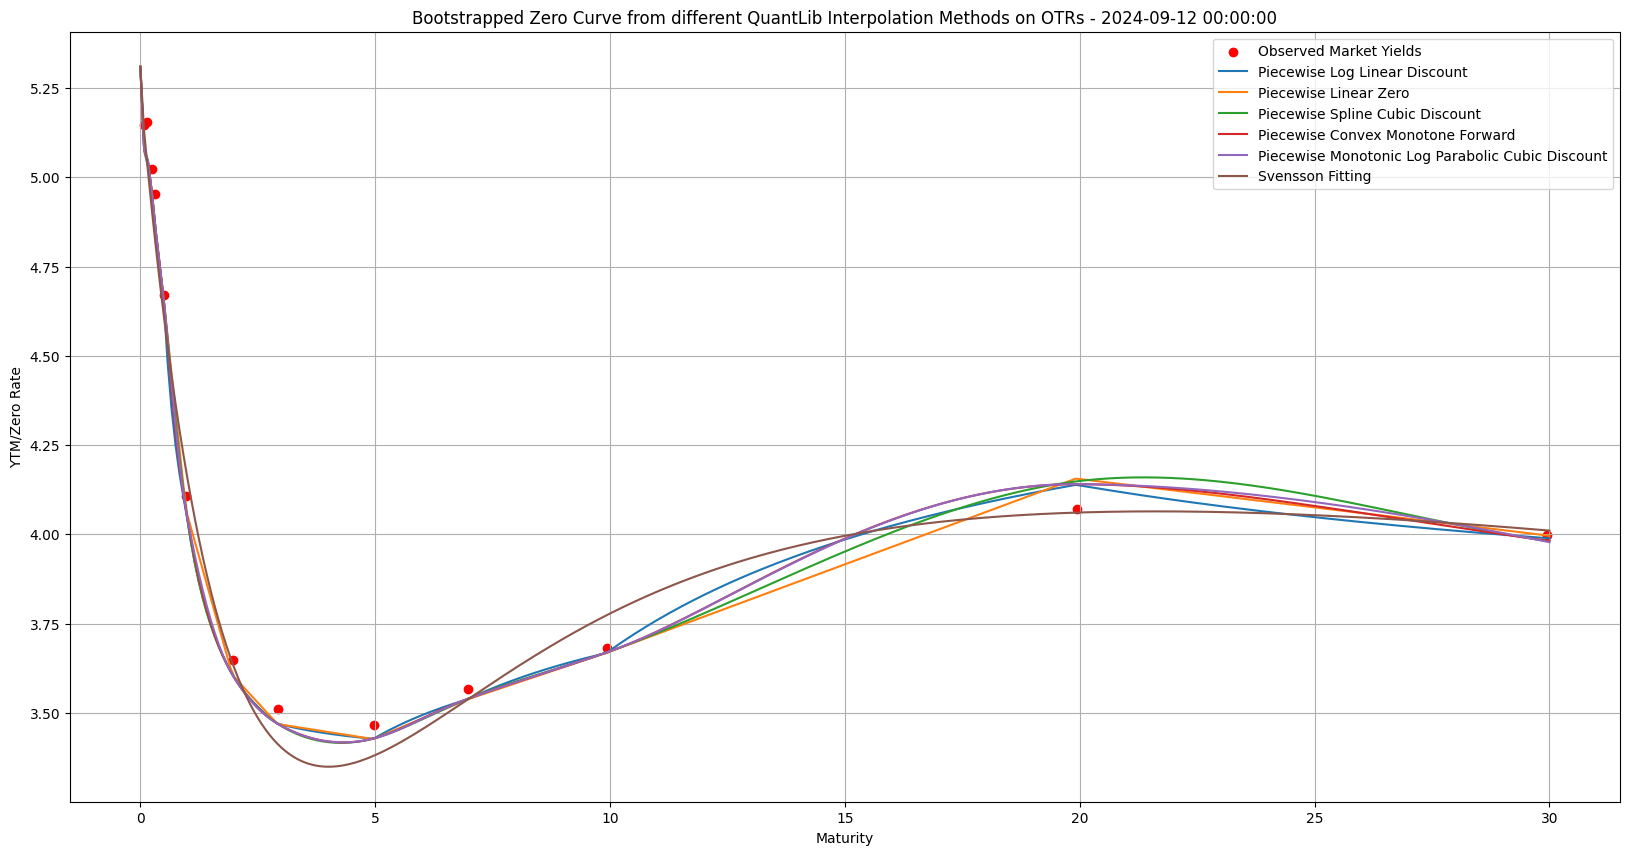

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(
    curve_set_otr_df["time_to_maturity"],
    curve_set_otr_df[f"{quote_type}_yield"],
    color="red",
    label="Observed Market Yields",
)

for bs_method in bs_methods:
    plt.plot(
        cc_spot_rates_dict["spot_rate_df"]["time_to_maturity"],
        cc_spot_rates_dict["spot_rate_df"][f"{bs_method}_spot_rate"],
        label=f"{ql_piecewise_method_pretty(bs_method)}",
    )

plt.title(
    f"Bootstrapped Zero Curve from different QuantLib Interpolation Methods on OTRs - {as_of_date}"
)
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()

## Using Parametric Models for Curve Construction/Zero Curve Estimation:

In [13]:
def parametric_zero_curve_plot(curve_set_df: pd.DataFrame, title: str, ytm_col=f"{quote_type}_yield"):
    plt.figure(figsize=(20, 10))
    plt.scatter(
        curve_set_df["time_to_maturity"],
        curve_set_df[ytm_col],
        color="black",
        label="Observed Market Yields",
    )

    ttm_ls = np.linspace(0, 30, 1000)

    ns_func, status_ns = calibrate_ns_ols(
        curve_set_df["time_to_maturity"].to_numpy(),
        curve_set_df[ytm_col].to_numpy(),
    )
    assert status_ns
    plt.plot(
        ttm_ls,
        ns_func(ttm_ls),
        label="Zero Curve - Nelson-Siegel OLS-Based-Calibration",
    )

    nss_func, status_nss, _ = calibrate_nss_ols(
        curve_set_df["time_to_maturity"].to_numpy(),
        curve_set_df[ytm_col].to_numpy(),
    )
    assert status_nss
    plt.plot(
        ttm_ls,
        nss_func(ttm_ls),
        label="Zero Curve - Nelson-Siegel-Svensson OLS-Based-Calibration",
    )

    mles_func, status_mles = calibrate_mles_ols(
        curve_set_df["time_to_maturity"].to_numpy(),
        curve_set_df[ytm_col].to_numpy(),
        overnight_rate=5.31,
        N=9,
    )
    assert status_mles
    plt.plot(
        ttm_ls,
        mles_func(ttm_ls),
        label="Zero Curve - Merrill Lynch Exponential Spline OLS-Based-Calibration",
    )

    plt.title(title)
    plt.xlabel("Maturity")
    plt.ylabel("YTM/Zero Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:47: RuntimeWarning: invalid value encountered in log
  return -np.log(prices) / maturities * 100
c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:36: RuntimeWarning: overflow encountered in matmul
  return np.linalg.inv(H.T @ W @ H) @ H.T @ W @ p
c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:47: RuntimeWarning: invalid value encountered in log
  return -np.log(prices) / maturities * 100
c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:36: RuntimeWarning: overflow encountered in matmul
  return np.linalg.inv(H.T @ W @ H) @ H.T @ W @ p
c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:22: RuntimeWarning: overflow encountered in exp
  return np.exp(-self.alpha * k * T)
c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:36: RuntimeWarning: invalid value encountered in matmul
  return np.linalg.inv(H.T @ W @ H) @ H.T @ W @ p
c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:22: RuntimeWarning: overflow encountered in exp
  return np.exp(-self.alpha * k * T)
c:\Users\chris\Curvy

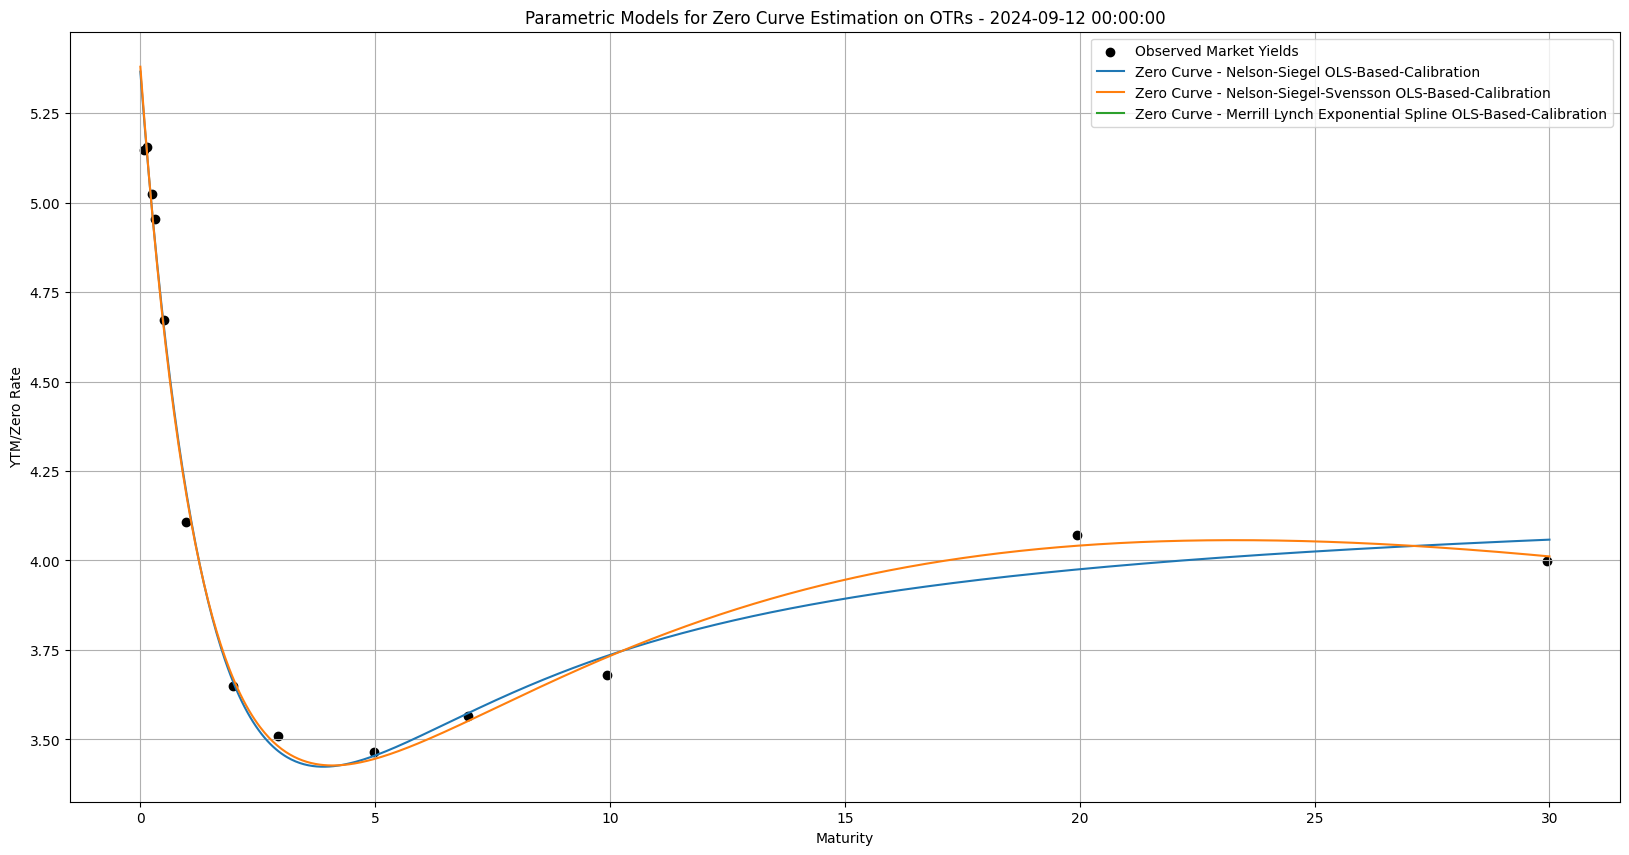

In [15]:
parametric_zero_curve_plot(curve_set_df=curve_set_otr_df, title=f"Parametric Models for Zero Curve Estimation on OTRs - {as_of_date}")

c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:47: RuntimeWarning: divide by zero encountered in divide
  return -np.log(prices) / maturities * 100


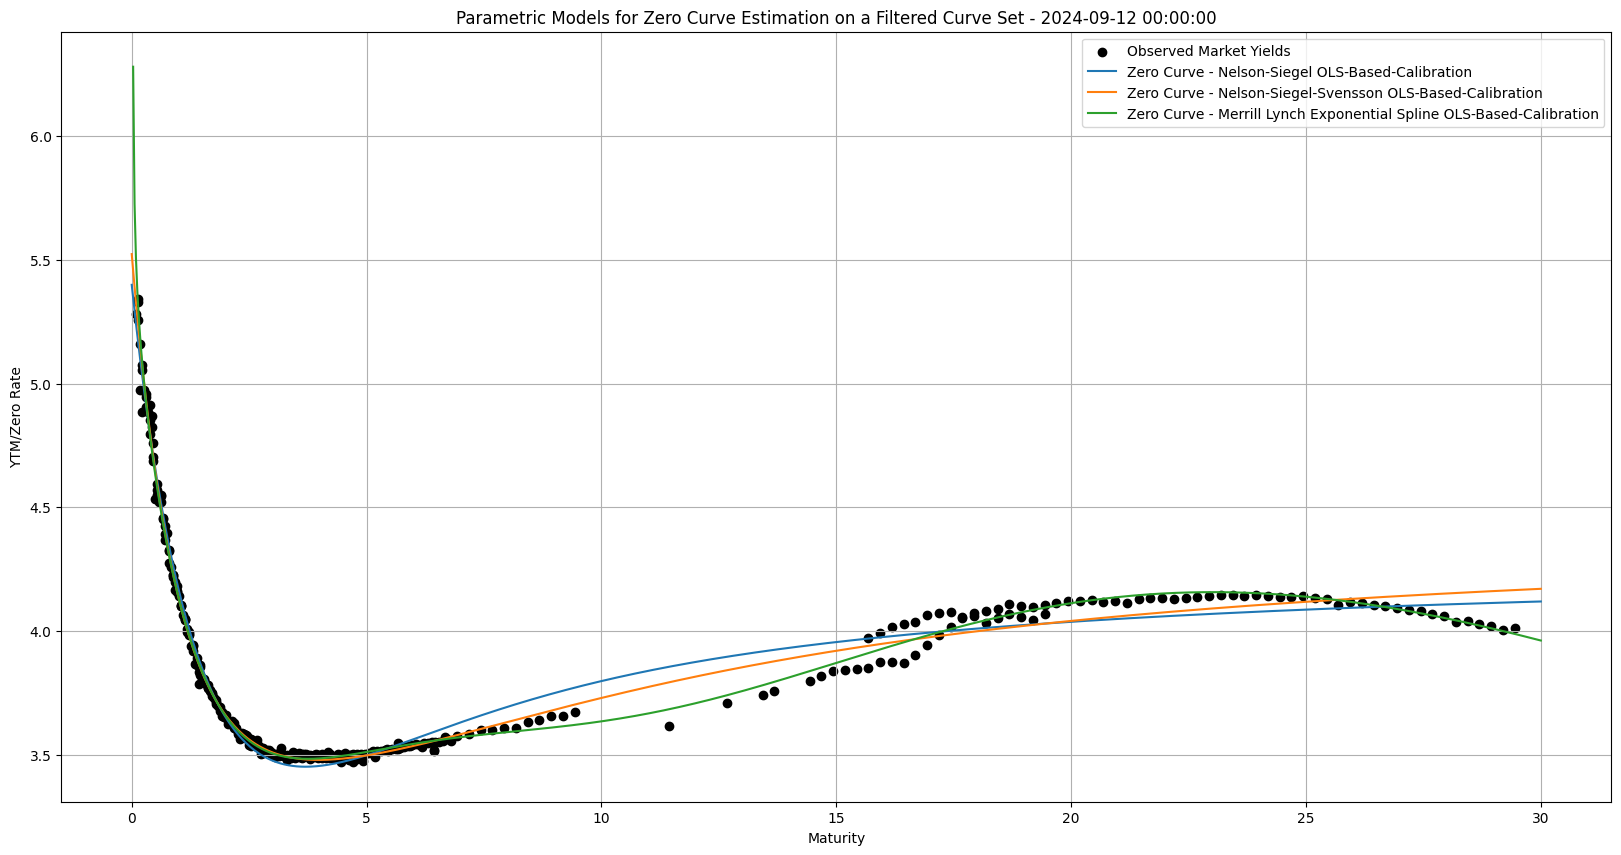

In [16]:
parametric_zero_curve_plot(curve_set_df=curve_set_filtered_df, title=f"Parametric Models for Zero Curve Estimation on a Filtered Curve Set - {as_of_date}")

## Using Splines/Interpolation Methods for Curve Construction:

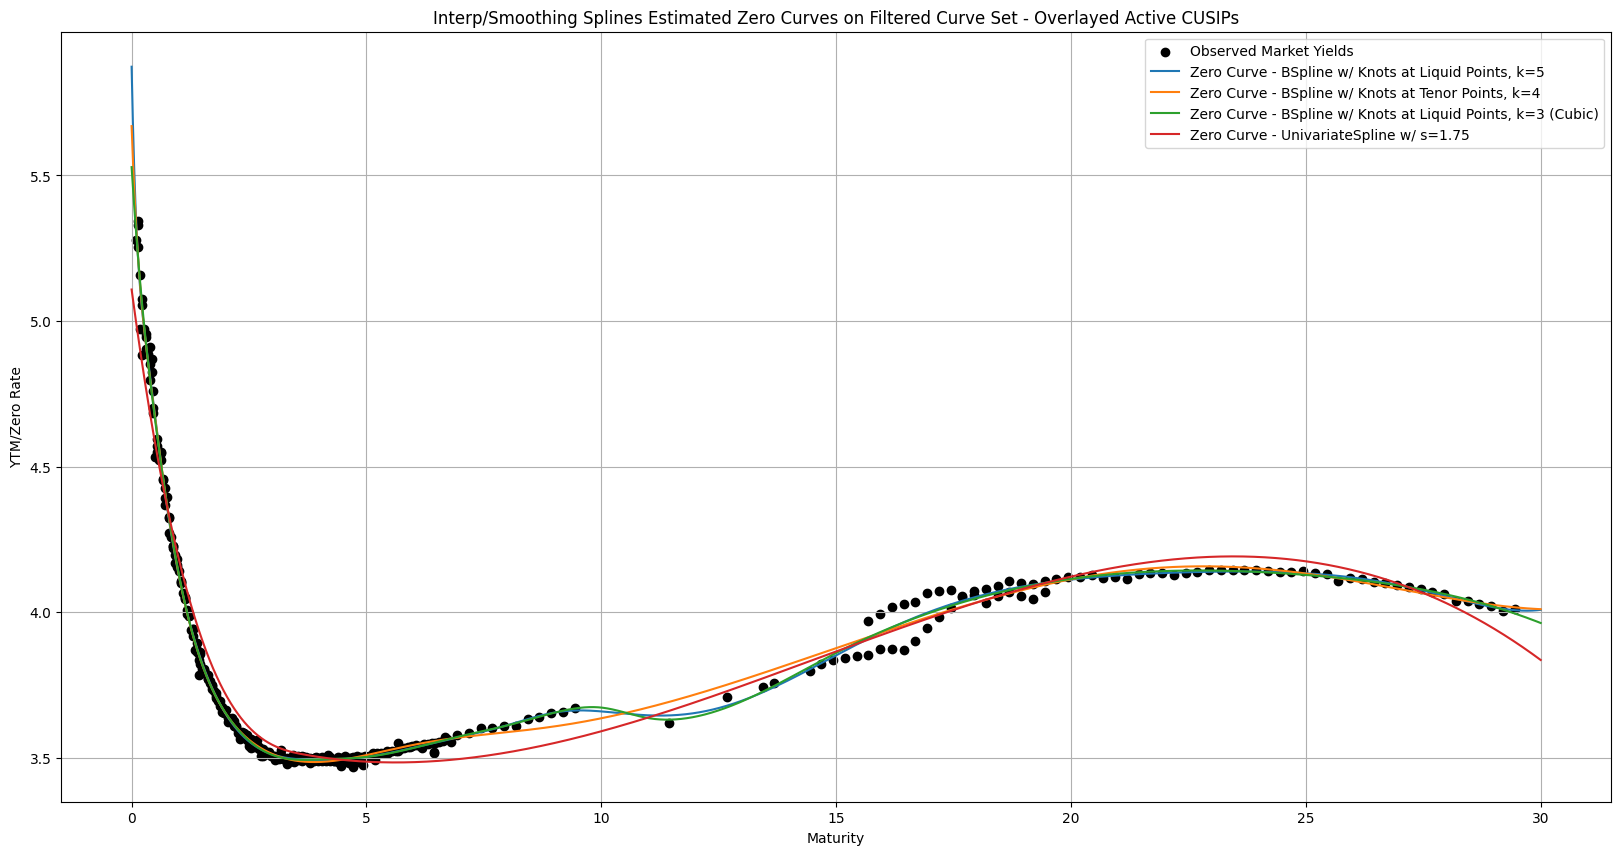

In [17]:
plt.figure(figsize=(20, 10))
plt.scatter(
    curve_set_filtered_df["time_to_maturity"],
    curve_set_filtered_df[f"{quote_type}_yield"],
    label="Observed Market Yields",
    color="black",
)

ttm_ls = np.linspace(0, 30, 10000)

curve_interpolater = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
bspline_func1 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 20, 25], k=5, return_func=True
)
bspline_func2 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 5, 7, 10, 20], k=4, return_func=True
)
bspline_func3 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25], k=3, return_func=True
)

plt.plot(
    ttm_ls,
    bspline_func1(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Liquid Points, k=5",
)
plt.plot(
    ttm_ls,
    bspline_func2(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Tenor Points, k=4",
)
plt.plot(
    ttm_ls,
    bspline_func3(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Liquid Points, k=3 (Cubic)",
)
s = 1.75
plt.plot(
    ttm_ls,
    curve_interpolater.univariate_spline(s=s, return_func=True)(ttm_ls),
    label=f"Zero Curve - UnivariateSpline w/ s={s}",
)


plt.title("Interp/Smoothing Splines Estimated Zero Curves on Filtered Curve Set - Overlayed Active CUSIPs")
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# splines assume that function is well-defined
# duplicate x values with different y-values breaks the assumption of a well-defined function
# we weight market observed ytms by their free float
# allows us to use more interpolation methods

free_float_weighted_curve_set_df = (
    curve_set_filtered_df.groupby("time_to_maturity")
    .apply(
        lambda x: (x[f"{quote_type}_yield"] * x["free_float"]).sum()
        / x["free_float"].sum(), include_groups=False
    )
    .reset_index(name="free_float_weighted_ytm")
)
free_float_weighted_curve_set_df

,time_to_maturity,free_float_weighted_ytm
0,0.090411,5.279319
1,0.134247,5.299273
2,0.175342,5.069578
3,0.216438,4.986634
4,0.257534,4.972985
...,...,...
201,28.446575,4.039219
202,28.690411,4.029203
203,28.942466,4.019952
204,29.194521,4.002844


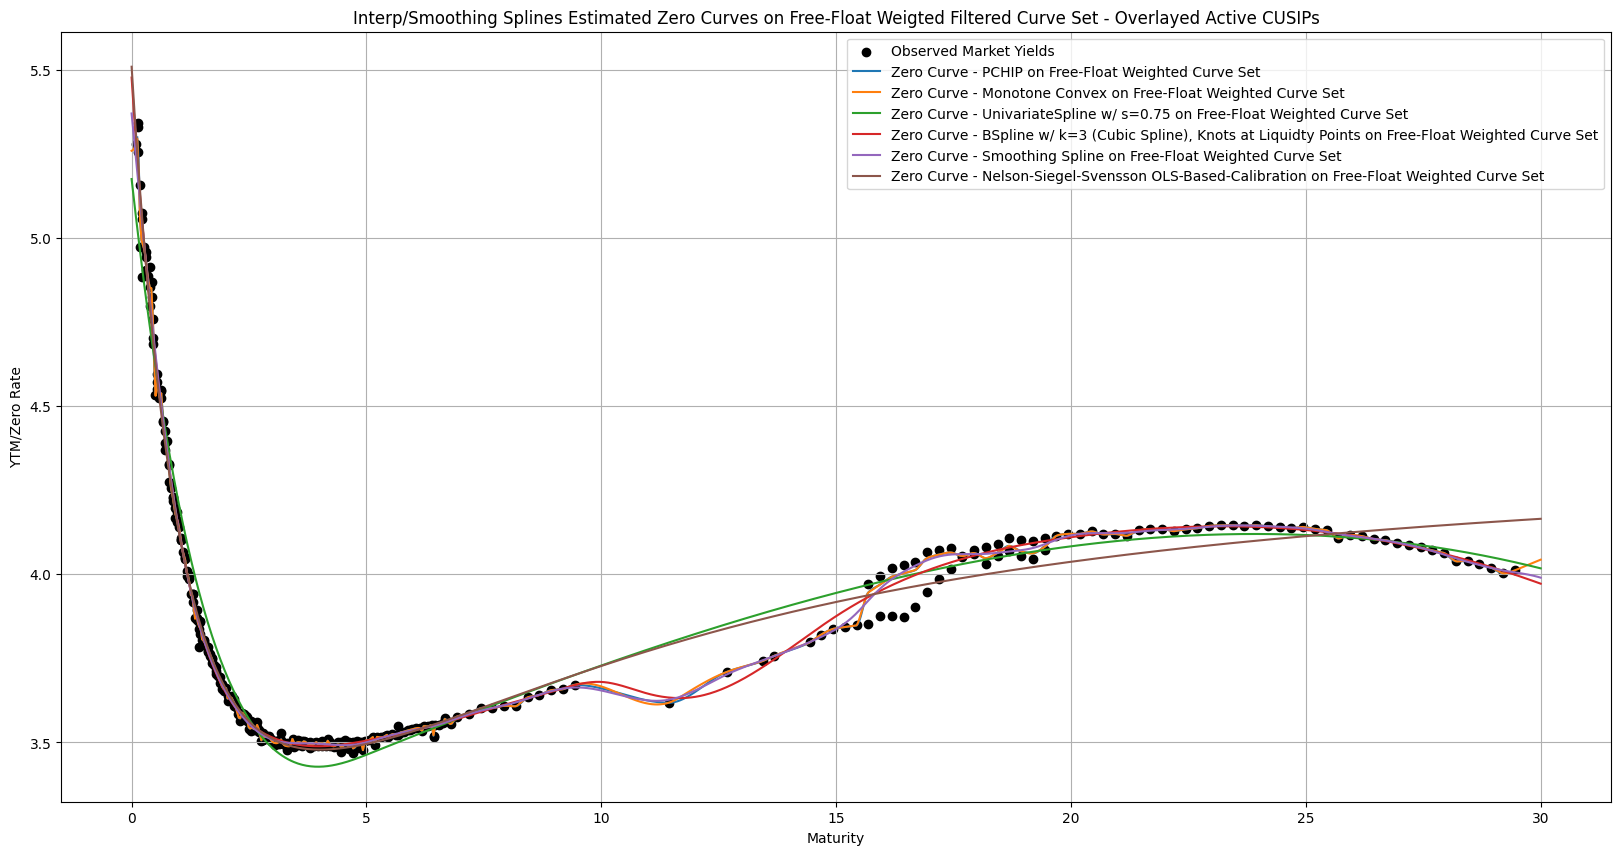

In [19]:
plt.figure(figsize=(20, 10))
plt.scatter(
    curve_set_filtered_df["time_to_maturity"],
    curve_set_filtered_df[f"{quote_type}_yield"],
    label="Observed Market Yields",
    color="black",
)

ttm_ls = np.linspace(0, 30, 1000)

# interpolations
float_weighted_curve_interpolater = GeneralCurveInterpolator(
    x=free_float_weighted_curve_set_df["time_to_maturity"].to_numpy(),
    y=free_float_weighted_curve_set_df["free_float_weighted_ytm"].to_numpy(),
)
plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.pchip_interpolation(return_func=True)(ttm_ls),
    label="Zero Curve - PCHIP on Free-Float Weighted Curve Set",
)

plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.monotone_convex()(ttm_ls),
    label="Zero Curve - Monotone Convex on Free-Float Weighted Curve Set",
)

# smooth splines
s = 0.75
plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.univariate_spline(s=s, return_func=True)(ttm_ls),
    label=f"Zero Curve - UnivariateSpline w/ s={s} on Free-Float Weighted Curve Set",
)

plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25], k=3, return_func=True
    )(ttm_ls),
    label=f"Zero Curve - BSpline w/ k=3 (Cubic Spline), Knots at Liquidty Points on Free-Float Weighted Curve Set",
)

plt.plot(
    ttm_ls,
    float_weighted_curve_interpolater.smoothing_spline()(ttm_ls),
    label=f"Zero Curve - Smoothing Spline on Free-Float Weighted Curve Set",
)

# parametric model
nss_func, status_nss, _ = calibrate_nss_ols(
    free_float_weighted_curve_set_df["time_to_maturity"].to_numpy(),
    free_float_weighted_curve_set_df["free_float_weighted_ytm"].to_numpy(),
)
assert status_nss
plt.plot(
    ttm_ls,
    nss_func(ttm_ls),
    label="Zero Curve - Nelson-Siegel-Svensson OLS-Based-Calibration on Free-Float Weighted Curve Set",
)

plt.title("Interp/Smoothing Splines Estimated Zero Curves on Free-Float Weigted Filtered Curve Set - Overlayed Active CUSIPs")
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()

## Par Curve from Estimated Zero Curves

In [20]:
def par_bond_equation(c, maturity, zero_curve_func):
    discounted_cash_flows = sum(
        (c / 2) * np.exp(-(zero_curve_func(t) / 100) * t)
        for t in np.arange(0.5, maturity + 0.5, 0.5)
    )
    final_payment = 100 * np.exp(-(zero_curve_func(maturity) / 100) * maturity)
    return discounted_cash_flows + final_payment - 100

def par_curve_func(tenor, zero_curve_func):
    init_guess = 4
    return newton(par_bond_equation, x0=init_guess, args=(tenor, zero_curve_func))

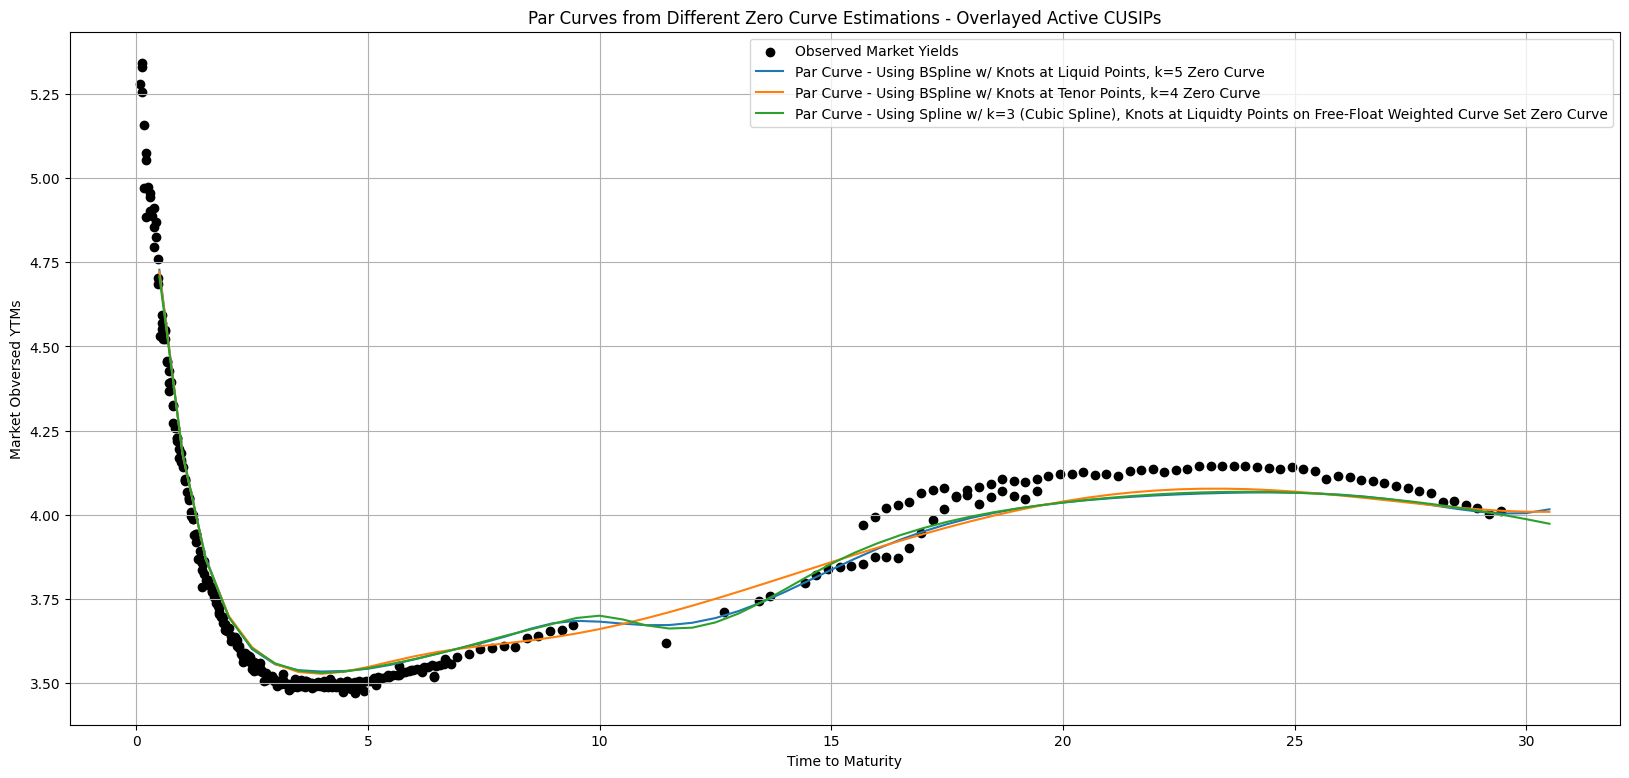

In [21]:
plt.figure(figsize=(20, 9))
plt.scatter(
    curve_set_filtered_df["time_to_maturity"],
    curve_set_filtered_df[f"{quote_type}_yield"],
    color="black",
    label="Observed Market Yields",
)

t2 = np.arange(0.5, 30 + 1, 0.5)
plt.plot(
    t2,
    [par_curve_func(t, bspline_func1) for t in t2],
    label="Par Curve - Using BSpline w/ Knots at Liquid Points, k=5 Zero Curve",
)
plt.plot(
    t2,
    [par_curve_func(t, bspline_func2) for t in t2],
    label="Par Curve - Using BSpline w/ Knots at Tenor Points, k=4 Zero Curve",
)
plt.plot(
    t2,
    [
        par_curve_func(
            t,
            float_weighted_curve_interpolater.b_spline_with_knots_interpolation(
                knots=[0.5, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
                k=3,
                return_func=True,
            ),
        )
        for t in t2
    ],
    label="Par Curve - Using Spline w/ k=3 (Cubic Spline), Knots at Liquidty Points on Free-Float Weighted Curve Set Zero Curve",
)


plt.xlabel("Time to Maturity")
plt.ylabel("Market Obversed YTMs")
plt.title("Par Curves from Different Zero Curve Estimations - Overlayed Active CUSIPs")
plt.legend()
plt.grid(True)
plt.show()

## Interpolating/Fitting on Market Observed Zeros (P-STRIPs, C-STRIPs, TBills):

In [22]:
# TBills and CSTRIPs
market_obs_zeros_cstrips_df = pd.concat(
    [
        tbill_quotes_df.rename(
            columns={"tbill_price": "obsv_price", "tbill_ytm": "obsv_ytm"}
        ),
        cstrips_quotes_df.rename(
            columns={"cstrip_price": "obsv_price", "cstrip_ytm": "obsv_ytm"}
        ),
    ]
)
market_obs_zeros_cstrips_df = market_obs_zeros_cstrips_df.sort_values(
    by=["time_to_maturity"]
).drop_duplicates(subset=["time_to_maturity"])

market_obs_zeros_cstrips_df

,cusip,label,maturity_date,time_to_maturity,obsv_price,obsv_ytm
0,912797LH8,"Sep 24s, 17-Week",2024-09-17,0.013699,99.9392,5.468179
13,912797KL0,"Sep 24s, 26-Week",2024-09-19,0.019178,99.9088,5.468179
1,912797LJ4,"Sep 24s, 17-Week",2024-09-24,0.032877,99.8180,5.955778
14,912797KM8,"Sep 24s, 26-Week",2024-09-26,0.038356,99.7913,5.778926
2,912797LK1,"Oct 24s, 17-Week",2024-10-01,0.052055,99.7262,5.475081
...,...,...,...,...,...,...
105,912834D47,"Aug 52, UST STRIPPED INT PMT",2052-08-15,27.942466,32.1807,4.144389
106,912834F29,"Nov 52, UST STRIPPED INT PMT",2052-11-15,28.194521,32.1555,4.109534
107,912834G93,"May 53, UST STRIPPED INT PMT",2053-05-15,28.690411,31.9216,4.063463
108,912834H84,"Aug 53, UST STRIPPED INT PMT",2053-08-15,28.942466,31.8538,4.034989


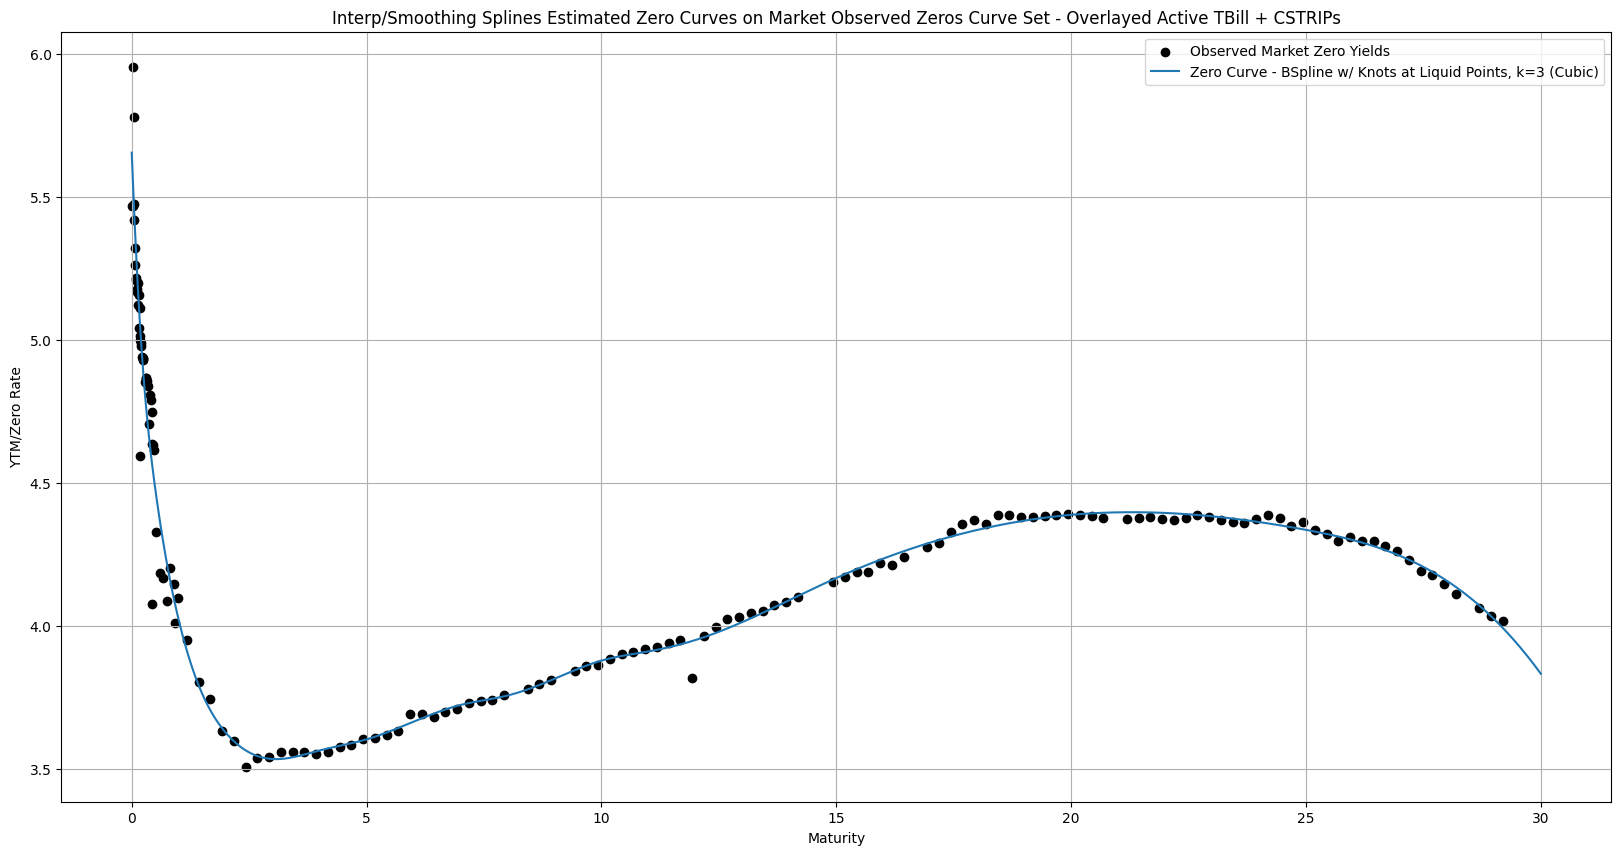

In [23]:
plt.figure(figsize=(20, 10))
plt.scatter(
    market_obs_zeros_cstrips_df["time_to_maturity"],
    market_obs_zeros_cstrips_df["obsv_ytm"],
    label="Observed Market Zero Yields",
    color="black",
)

ttm_ls = np.linspace(0, 30, 1000)

curve_interpolater = GeneralCurveInterpolator(
    x=market_obs_zeros_cstrips_df["time_to_maturity"].to_numpy(),
    y=market_obs_zeros_cstrips_df["obsv_ytm"].to_numpy(),
)

bspline_func3 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25], k=3, return_func=True
)

plt.plot(
    ttm_ls,
    bspline_func3(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Liquid Points, k=3 (Cubic)",
)

plt.title("Interp/Smoothing Splines Estimated Zero Curves on Market Observed Zeros Curve Set - Overlayed Active TBill + CSTRIPs")
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# TBills and PSTRIPs
market_obs_zeros_pstrips_df = pd.concat(
    [
        tbill_quotes_df.rename(
            columns={"tbill_price": "obsv_price", "tbill_ytm": "obsv_ytm"}
        ),
        pstrips_quotes_df.rename(
            columns={"pstrip_price": "obsv_price", "pstrip_ytm": "obsv_ytm"}
        ),
    ]
)
market_obs_zeros_pstrips_df = market_obs_zeros_pstrips_df.sort_values(
    by=["time_to_maturity"]
).drop_duplicates(subset=["time_to_maturity"])

market_obs_zeros_pstrips_df

,cusip,label,maturity_date,time_to_maturity,obsv_price,obsv_ytm,issue_date,corpus_cusip
7,91282CCX7,"Sep 24s, 3-Year",2024-09-15,0.008219,99.9652,6.363385,2021-09-15,912821GJ8
0,912797LH8,"Sep 24s, 17-Week",2024-09-17,0.013699,99.9392,5.468179,NaT,NaN
13,912797KL0,"Sep 24s, 26-Week",2024-09-19,0.019178,99.9088,5.468179,NaT,NaN
1,912797LJ4,"Sep 24s, 17-Week",2024-09-24,0.032877,99.8180,5.955778,NaT,NaN
14,912797KM8,"Sep 24s, 26-Week",2024-09-26,0.038356,99.7913,5.778926,NaT,NaN
...,...,...,...,...,...,...,...,...
186,912810SX7,"May 51s, 30-Year",2051-05-15,26.687671,34.1692,4.108803,2021-07-15,912803FY4
187,912810SZ2,"Aug 51s, 30-Year",2051-08-15,26.939726,33.8879,4.101531,2021-10-15,912803GA5
188,912810TD0,"Feb 52s, 30-Year",2052-02-15,27.443836,33.4107,4.078625,2022-04-18,912803GE7
189,912810TJ7,"Aug 52s, 30-Year",2052-08-15,27.942466,33.0803,4.041601,2022-10-17,912803GK3


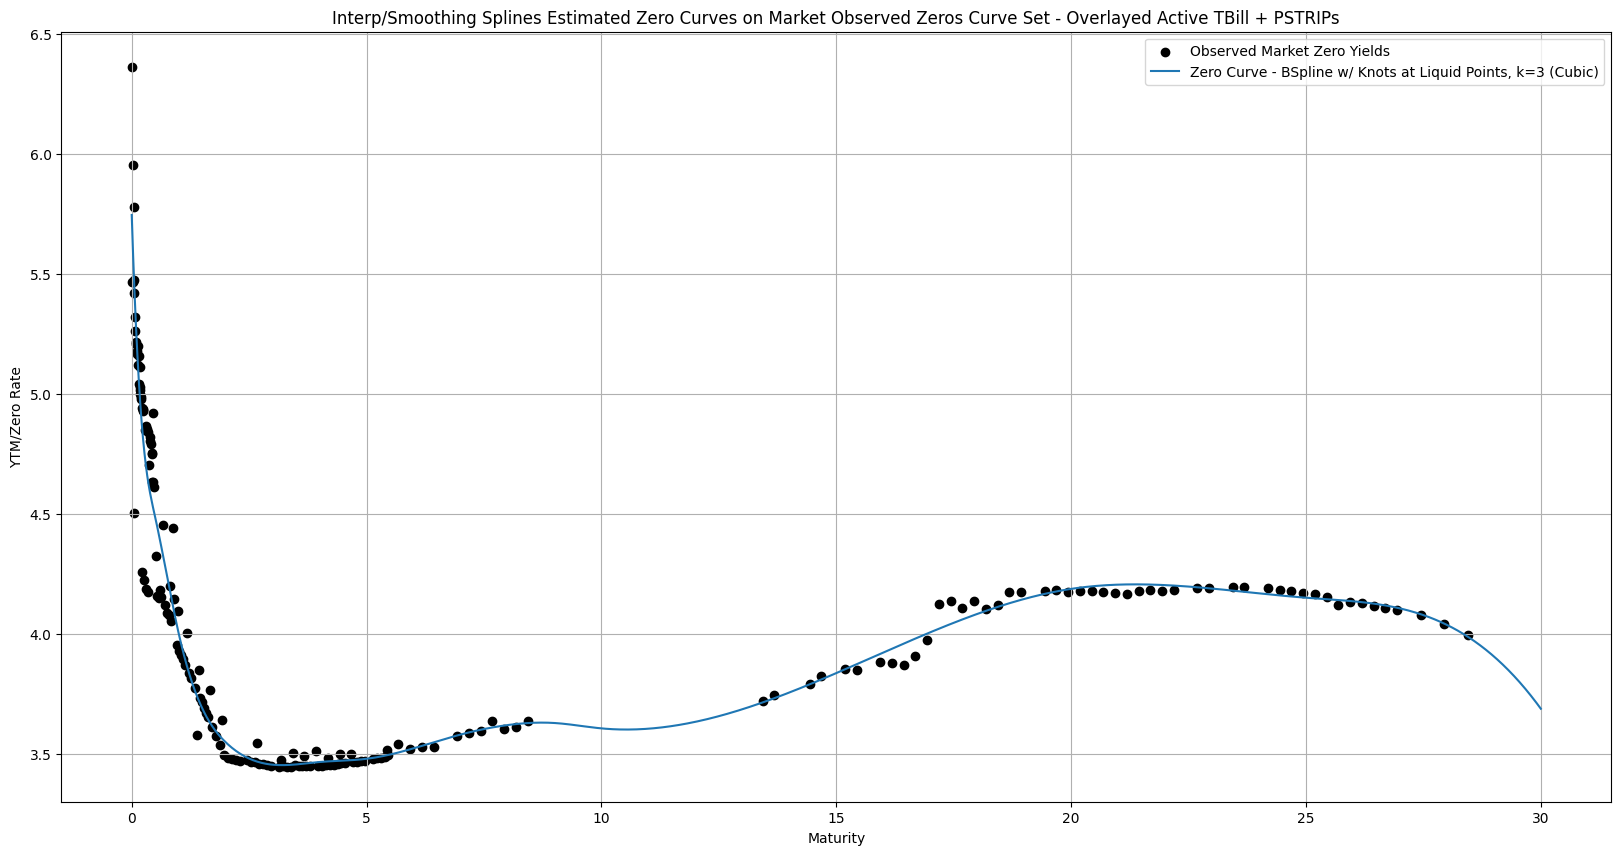

In [25]:
plt.figure(figsize=(20, 10))
plt.scatter(
    market_obs_zeros_pstrips_df["time_to_maturity"],
    market_obs_zeros_pstrips_df["obsv_ytm"],
    label="Observed Market Zero Yields",
    color="black",
)

ttm_ls = np.linspace(0, 30, 1000)

curve_interpolater = GeneralCurveInterpolator(
    x=market_obs_zeros_pstrips_df["time_to_maturity"].to_numpy(),
    y=market_obs_zeros_pstrips_df["obsv_ytm"].to_numpy(),
)

bspline_func3 = curve_interpolater.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 20, 25], k=3, return_func=True
)

plt.plot(
    ttm_ls,
    bspline_func3(ttm_ls),
    label="Zero Curve - BSpline w/ Knots at Liquid Points, k=3 (Cubic)",
)

plt.title("Interp/Smoothing Splines Estimated Zero Curves on Market Observed Zeros Curve Set - Overlayed Active TBill + PSTRIPs")
plt.xlabel("Maturity")
plt.ylabel("YTM/Zero Rate")
plt.legend()
plt.grid(True)
plt.show()